##Facial emotion recognition using Python
##Ali Khatai

##**Project Goals:**
For my Project, I will be performing Facial expression Recognition using the FER2013 Dataset. Facial Emotion recognition software allows a computer to detect emotion in human faces. It is basically a sentiment analysis tool which has many use cases such as market research and video game testing where companies can use such a tool to detect a users response to their product. Such a means of collecting market data is non-intrusive to users and can also be more reliable as it is not asking for the users response, but is instead getting it directly. This also helps to automate and scale data collection efforts and analyse data faster.

In this Project, I will be focus on 3 things which are as follows:
- **Implementing a convolutional neural network for emotion recognition:** Convolutional neural networks are a type of neural network used most commonly in images classification and processing. These type of networks use convolutional layers which allow the networks to learn certain features in input images. In my project I will be implementing convolutional neural networks with different architectures to determine which one would work best for my task.
- **Looking at the effects on basic data augmentation techniques on accuracy of the model**: Data augmentation is the process of applying transformation to your data which might help separate it from the original data whilst still being relevant to our use case. Basically, neural networks need a large amount of data to train well on and with data augmentation we are able to increase the size of our dataset. I will be using some basic transformations to augment and increase the size of my dataset and train a model on it to see how useful and affective data-augmentation is for emotion recognition
- **Using transfer learning to analyze the effects of transfer learning and maximizing the accuracy of the model:** Tranfer Learning is the use of a pre-trained model and its weights that was implemented for a similar problem. Here i will be looking at the effectiveness of tranfer learning and use it to maximize the accuracy.

###**Dataset:**
The dataset I will be using is called FER2013 which is an open-source dataset which is first, created for an ongoing project by Pierre-Luc Carrier and Aaron Courville, then shared publicly for a Kaggle competition. the data set contains 35,887 grayscale, each sized 48 X 48 pixels consisting of close-up shots of face images. Each image is labelled by a corresponding emotion which are:
- 0 : *Angry*
- 1 : *Disgust*
- 2 : *Fear*
- 3 : *Happy*
- 4 : *Sad*
- 5 : *Surprise*
- 6 : *Neutral*

The dataset can be found [here](https://www.kaggle.com/msambare/fer2013)

We will start by processing our dataset, implement our model, and then experiment with data-augmentation and transfer learning.

Here are the imports used throughout this notebook.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import clear_output

import time

import pandas as pd

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


Here, I am importing the dataset from my google drive. If you wish to run this notebook, you can save the dataset to your google drive and this code should allow you to import it. Again, the dataset can be found at [here](https://www.kaggle.com/msambare/fer2013)

In [ ]:
#fetch the dataset
df1 = pd.read_csv('/content/gdrive/My Drive/fer2013.csv')

# use the tail() function from pandas to view the last few rows of the dataset just to verify it
df1.tail()
df1

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The FER2013 dataset was used for a competition on Kaggle and as you can see in the cell above it was already split into a training, Public test and Private test set. There are about 28000 images in the training set and 3500 each in the Public and Privates test sets. Here I will be using just the Private testset as my testset ,and the training and public testset will be combined to form my training set. We first have to split the pixel data by spaces as that's how it was in the dataset and then divide each image by 255 to bring the pixels in the range from 0 to 1. Then we just split the data into train and test sets.

In [ ]:
# convert the images and labels to a list. set_type contain string that indicate the set type of the data.
images = df1['pixels'].tolist()
set_type = df1['Usage'].tolist()
Y = df1['emotion'].tolist()

trainX = []
testX= []
trainY = []
testY = []

# loop through the entire dataset and do some required preprocessing on images. Split the data into training and test sets according to thier indicated set type.
for x in range(len(images)):
  face = images[x].split(" ")
  face = np.asarray(face).reshape(48,48)
  face = face.astype(np.float32)
  face = np.true_divide(face,255.0)
  if set_type[x] == "Training" or set_type[x] == "PublicTest":
    trainX.append(face)
    trainY.append(Y[x])
  else:
    testX.append(face)
    testY.append(Y[x])

# convert the data to numpy arrays
trainX = np.array(trainX)
testX= np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


trainX shape: (32298, 48, 48)
trainY shape: (32298,)
testX shape: (3589, 48, 48)
testY shape: (3589,)
Emotion: angry


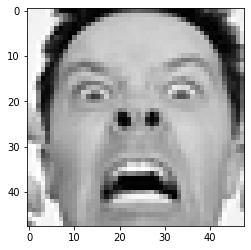

In [ ]:
# verify the shapes of the data
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")

# this list stores the labels at the corresponding indexes
classes= ["angry","disgust","fear","happy","sad","surprise","neutral"]

#display an image with its label
plt.imshow(trainX[15000],cmap=plt.cm.gray)
print("Emotion: "+classes[trainY[15000]])

We can now normalize the data and create the data loaders

In [ ]:
# this transform object will be used to normalize the data
normalize_transform = torchvision.transforms.Normalize(trainX.mean(), trainX.std())

# normalize the data and convert them into tensors
tensortrainX = normalize_transform(torch.tensor(trainX))
tensortestX = normalize_transform(torch.tensor(testX))

tensortrainY = torch.tensor(trainY)
tensortestY = torch.tensor(testY)

# Make the train and test datasets
train_data = torch.utils.data.TensorDataset(tensortrainX, tensortrainY)
test_data = torch.utils.data.TensorDataset(tensortestX, tensortestY)

# Make the data loaders
batch_size = 64
dl_train = torch.utils.data.DataLoader(train_data, batch_size,num_workers = 2)
dl_test = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 2)

# verify the shapes again
print(f"trainset shape : {train_data[:][0].shape}")
print(f"testset shape : {test_data[:][0].shape}")

trainset shape : torch.Size([32298, 48, 48])
testset shape : torch.Size([3589, 48, 48])


#**Helper functions**
This cell contains function that were written by Prof. Mark liffiton. I will be using these function to display images and their predictions , and get training statisitcs for my models

In [ ]:
# Helper functions for displaying example images with labels written by Prof. Mark Liffiton

# displays images in a single figure
def show_images(images, titles, cols = 1):
    """Display a list of images in a single figure with matplotlib.
    Adapted from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    titles: List of titles corresponding to each image. Must have
            the same length as images.

    cols (Default = 1): Number of columns in figure (number of rows is
                        set to np.ceil(n_images/float(cols))).

    """
    n_images = len(images)
    rows = np.ceil(n_images/float(cols))
    classes= ["angry","disgust","fear","happy","sad","surprise","neutral"]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, cols, n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.colorbar()
        a.axis('off')
        a.set_title(title)

    fig.set_size_inches([cols*3.3, rows*3.3])
    plt.show()


def show_images2(images, titles, cols = 1):
    n_images = len(images)
    rows = np.ceil(n_images/float(cols))
    classes= ["angry","disgust","fear","happy","sad","surprise","neutral"]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, cols, n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.colorbar()
        a.axis('off')
        a.set_title(classes[title])

    fig.set_size_inches([cols*3.3, rows*3.3])
    plt.show()

# displays images from a dataloader witht their corresponding labels
def show_examples(dataloader, maxcount=10):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = [img.numpy() for img in images][:maxcount]
    labels = [l.item() for l in labels][:maxcount]
    show_images2(images, labels, cols=5)

# displays images with their corresponding labels and prediction from a given model
def show_examples_test(dataloader, model, mincount ,maxcount):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        predictions = model(images)
    images = [img.cpu().numpy() for img in images][mincount:maxcount]
    classes= ["angry","disgust","fear","happy","sad","surprise","neutral"]
    labels = [f"Actual={classes[l.item()]}\n prediction={classes[p.argmax()]}" for l,p in zip(labels,predictions)][:maxcount]
    show_images(images, labels, cols=5)

def get_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)

    overall_acc = (predicted == labels).sum() / labels.shape[0]

    return overall_acc

def check_accuracy(dataloader, network):
    with torch.no_grad():
        test_outputs = torch.tensor([]).to(device)
        test_labels = torch.tensor([]).to(device)
        for data in dataloader:
            inputs, labels = [x.to(device) for x in data]
            outputs = network(inputs)
            test_outputs = torch.cat((test_outputs, outputs))
            test_labels = torch.cat((test_labels, labels))
        accuracy = get_accuracy(test_outputs, test_labels)
        return accuracy

def plot_loss_acc(losses, accuracies):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel("Loss (Training)", color="blue")
    ax.set_xlabel("Epoch")
    ax.plot(range(1, len(losses)+1), losses, color="blue")
    ax2 = ax.twinx()
    ax2.set_ylabel("Accuracy (Test)", color="orange")
    ax2.plot(range(1, len(losses)+1), accuracies, color="orange")
    #ax2.set_ybound(-0.01, 1.01)
    plt.show()

def test_model(model, dataloader):
    classes = ["angry","disgust","fear","happy","sad","surprise","neutral"]
    class_correct = {clsname: 0 for clsname in classes}
    class_total = {clsname: 0 for clsname in classes}
    total_correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]

            # forward
            outputs = model(inputs)

            # get predictions from multiple class outputs
            _, predicted = torch.max(outputs, 1)
            # find and count the correct predictions
            corrects = (predicted == labels).squeeze()
            total_correct += corrects.sum()
            total += outputs.shape[0]

            # count correct predictions within each clsas
            for label, correct in zip(labels, corrects):
                clsname = classes[label]
                class_correct[clsname] += correct.item()
                class_total[clsname] += 1
     # compute overall accuracies
    accuracy = (total_correct / total).item()
    class_accuracies = {clsname: class_correct[clsname]/class_total[clsname]
                        for clsname in classes}

    return accuracy, class_accuracies

class StatReporter:
    def start(self):
        self.start_time = time.time()
        self.elapsed = 0
        self.target = 0
        self.loss = None

    def iteration(self, epoch, i, loss):
        self.loss = loss

        iteration_time = time.time() - self.start_time
        self.elapsed += iteration_time
        self.start_time = time.time()
        if self.elapsed > self.target:
            print(f"Epoch {epoch+1:2d}, iteration {i+1:3d}:  Loss = {loss:.3f}  Iteration time = {iteration_time:0.3f}")
            self.target += 10

    def end(self):
        print(f"Training complete.  Elapsed time: {self.elapsed:.2f} seconds  Final loss: {self.loss:0.3f}")

stats = StatReporter()  # one StateReporter object to use throughout

We can Display some images from our data set


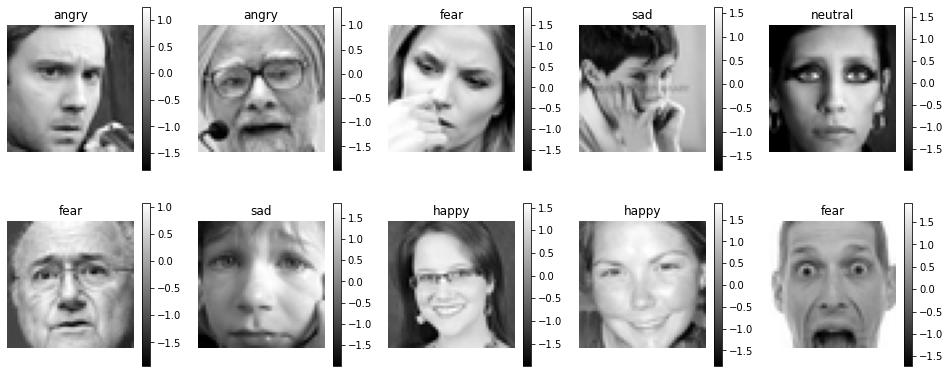

In [ ]:
show_examples(dl_train)




#**Implementing the model**

Now we will implement 3 convolutional neural network models with different architechures. We will be train them and examining their results to determine which one works the best for our usecase. All the models were trained with a learning rate of 0.001, Betas of (0.9, 0.999) and weight decay coefficients of 0.0001.

In [ ]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


Below is the train model function which will be used to train our model

In [ ]:
def train_model(model, loss_func, optimizer, traindata, testdata, epochs):
    start_time = plot_start_time = time.time()

    losses = []
    accuracies = []
    start_time = time.time()
    for epoch in range(epochs):
        for i, data in enumerate(traindata):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            # backprop
            loss = loss_func(outputs, labels)
            loss.backward()
            # optimize (update weights)
            optimizer.step()

        # Once per epoch, collect current loss and accuracy statistics.
        # Possibly plot the loss and accuracy traces (max once per second).

        # Get our current accuracy on the *test* set
        accuracy = check_accuracy(testdata, model)

        # Accumulate the loss/accuracy values for plotting
        losses.append(loss)
        accuracies.append(accuracy)

        # Update at once per second (plus at the start and end)
        # Updating the plot slows the computation dramatically, hence the
        # controlled rate.
        if time.time()-plot_start_time > 1:
            # Plot the cost function over the iterations completed so far
            clear_output(wait=True)
            plot_loss_acc(losses, accuracies)
            plot_start_time = time.time()  # store a new time for triggering the next update

            print(f"epoch: {epoch}")
            print(f"Loss: {loss:0.3f}")
            print(f"Accuracy (test set): {accuracy:0.3f}")
    end_time = time.time() - start_time
    print(f"Training complete.  Elapsed time: {end_time} seconds")

##**First Model**

Our first model is just a small convolutional network with 2 conv layes, max pool layers, and then 1 hidden layer. Training this network with 30 epochs gave us and accuracy of 48, but on the plot we can see that the accuracy reaches the highest point around 10-15 epochs and just starts going down after that. This suggests that after 15 epochs the model starts overfitting and therefore it is best to only train this model for 10-15 epochs. After retraining for 10 epochs the model achieved 52% accuracy

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 16, 3)
        self.fc1 = nn.Linear(16 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 10)


    def forward(self, x):
        x = x[:, None, :, :]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

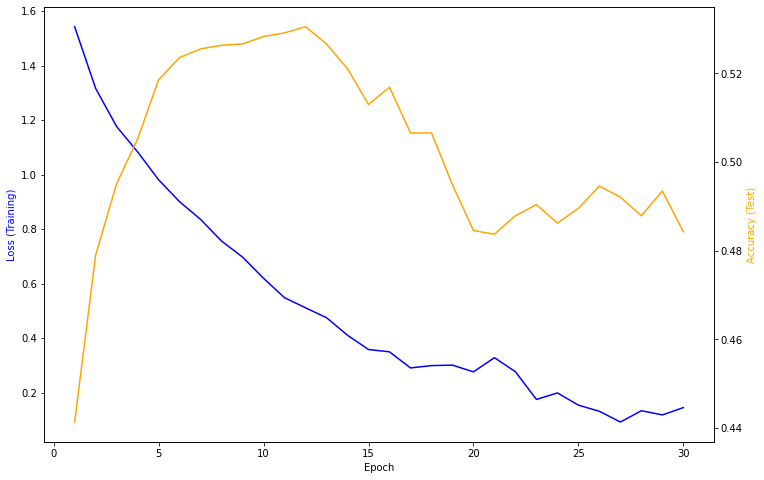

epoch: 29
Loss: 0.145
Accuracy (test set): 0.484
Training complete.  Elapsed time: 112.21059989929199 seconds


In [ ]:
# train with adam
net = CNN1()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net,criterion,optimizer,dl_train,dl_test,30)

Training this network with 30 epochs gave us and accuracy of 48%, but on the plot above we can see that the accuracy reaches the highest point around 10-15 epochs and just starts going down after that. This suggests that are 15 epochs the model starts overfitting and therefore it is best to only train this model for 10-15 epochs. In the cell below we can also see that this model gave an accuracy of about 80% on the training set.

In [ ]:
test_model(net,dl_train)

(0.8056536316871643,
 {'angry': 0.6774988794262663,
  'disgust': 0.7865853658536586,
  'fear': 0.8312649684302199,
  'happy': 0.8363748458692971,
  'neutral': 0.7503589375448672,
  'sad': 0.8119642531460879,
  'surprise': 0.941717791411043})

Now we will train the same model again but this time we will do it just for 10 epochs

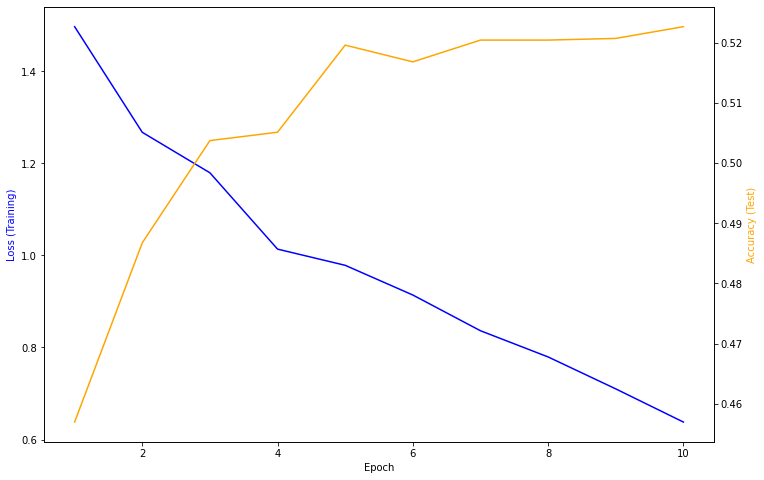

epoch: 9
Loss: 0.638
Accuracy (test set): 0.523
Training complete.  Elapsed time: 37.374488830566406 seconds


In [ ]:
# train with adam
net = CNN1()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net,criterion,optimizer,dl_train,dl_test,10)

In [ ]:
test_model(net,dl_train)

(0.6852746605873108,
 {'angry': 0.5421335723890632,
  'disgust': 0.3556910569105691,
  'fear': 0.446984541693882,
  'happy': 0.8537607891491985,
  'neutral': 0.7338478104809764,
  'sad': 0.6131679737370053,
  'surprise': 0.8675404350250976})

Now, after trainnig just for 10 epochs we got an accuracy of 52.2% which is an increase of about 4%. This the the accuracy on the training set went down to 68% from 80% which tells us that model is not overfitting as much as it was before

##**Second model**
The next model consists of three convolutional layers, 3 max pool layers and 2 hidden layers. In this model we also introduced batch normalization on the hidden layers and then also added dropout with 0.5 probability just before the final layer. This models also uses a greater number of neurons in each layers. Dropout was added to further reduce overfitting. Training this model for 30 epochs gave us an accuracy of 52.4%. The accuracy was showing an increasing trend so I trained it again for 70 epochs which took up the accuracy to 54.2 percent.

In [ ]:
class CNN2(nn.Module):
   def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64 , 5)
        self.conv3 = nn.Conv2d(64, 128 , 5)


        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(2*2*128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.50)

   def forward(self, x):
        x = x[:, None, :, :]

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

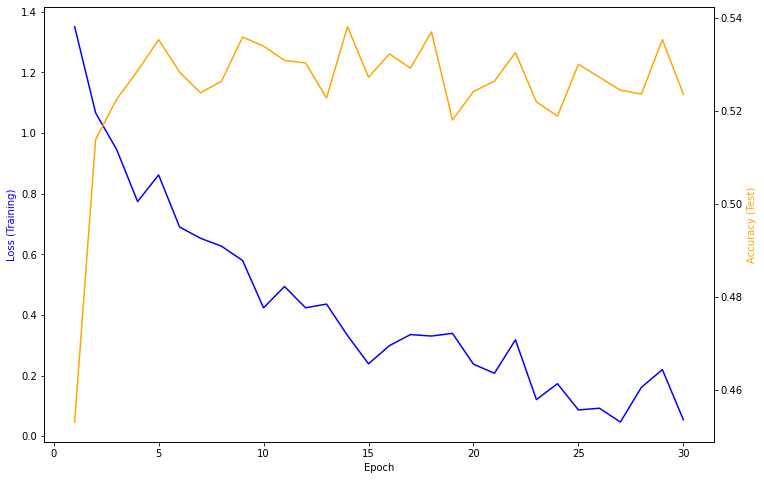

epoch: 29
Loss: 0.054
Accuracy (test set): 0.524
Training complete.  Elapsed time: 148.83453631401062 seconds


In [ ]:
# train with adam
net2 = CNN2()
net2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net2,criterion,optimizer,dl_train,dl_test,30)

We got 52.4% accuracy after 30 epochs. The plot kinda shows an increasing trend so we're gonna train this one again for 70 epochs.

In [ ]:
test_model(net2,dl_train)

(0.8420954942703247,
 {'angry': 0.7568354997758853,
  'disgust': 0.7682926829268293,
  'fear': 0.7892445025038102,
  'happy': 0.9382244143033293,
  'neutral': 0.797559224694903,
  'sad': 0.8216304942549699,
  'surprise': 0.9090909090909091})

Here are some images displayed with the labels and prediction from the model defined above

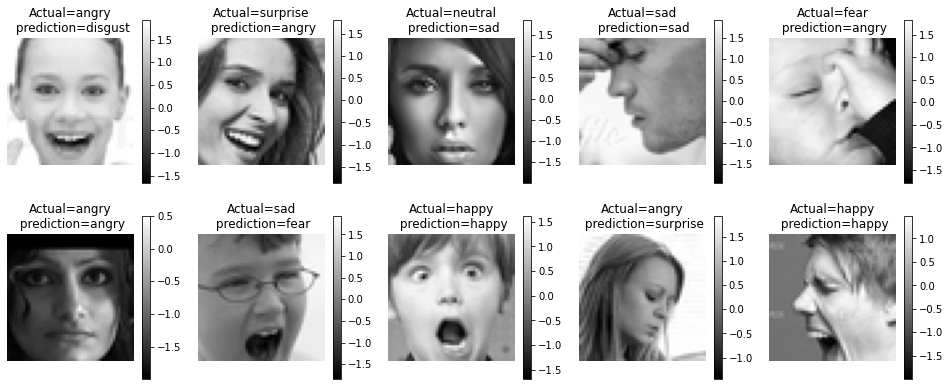

In [ ]:
# Display some perdictions
show_examples_test(dl_test,net2, 10,20)

Now train this model for 70 epochs

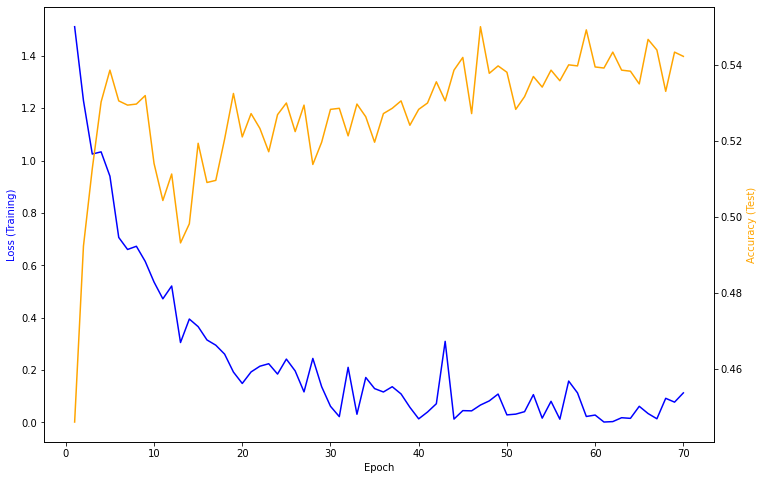

epoch: 69
Loss: 0.112
Accuracy (test set): 0.542
Training complete.  Elapsed time: 350.10556864738464 seconds


In [ ]:
net2 = CNN2()
net2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net2,criterion,optimizer,dl_train,dl_test,70)

In [ ]:
test_model(net2,dl_train)

(0.9495944380760193,
 {'angry': 0.9408337068579112,
  'disgust': 0.943089430894309,
  'fear': 0.9270629218375789,
  'happy': 0.9762022194821208,
  'neutral': 0.9380832735104092,
  'sad': 0.9471092467627211,
  'surprise': 0.9517568321249302})

Training for 70 epochs did gave an increase in accuracy of from 52% to 54%, but on the training set we got an accuracy of 94% which emans that this model is overfitting even more than the first one.

##**Third model**
Next, I decided to try out a much deeper network with 8 convolutional layers and then just a final fully connected layer. We also had batchnormalization after each layers. Max pooling was used in between some of the convolutional layers. I also added more dropout layers because the previous 2 models kept on overfitting. In our case a deeper network really didn't seem to help as the accuracy for this one was 45% which is the lowest of all of them. This model had an accuracy of 54% on the train set so it did a good job at not overfitting, but the overall accuracy on the test set was too low.

In [ ]:
class CNN4(nn.Module):

  def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64 , 1)
        self.Conv1bn = nn.BatchNorm2d(64)
        #pool
        #dropout
        self.conv3 = nn.Conv2d(64,128,1)
        self.Conv3bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,1)
        self.Conv4bn =  nn.BatchNorm2d(128)
        #pool
        #dropout
        self.conv5 = nn.Conv2d(128,256,1)
        self.Conv5bn = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,256,1)
        self.Conv6bn = nn.BatchNorm2d(256)
        #pool
        #dropout
        self.conv7 = nn.Conv2d(256,512,1)
        self.Conv7bn = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512,512,1)
        self.Conv8bn = nn.BatchNorm2d(512)
        #pool
        #dropout
        #flatten

        self.dropout = nn.Dropout(0.30)
        self.pool = nn.MaxPool2d(2, stride = 2)

        self.fc1 = nn.Linear(2*2*512, 512)
        # dropout
        self.fc2 = nn.Linear(512,7)

  def forward(self, x):

        x = x[:, None, :, :]

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv1bn(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.Conv3bn(x)
        x = self.conv4(x)
        x = self.Conv4bn(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.Conv5bn(x)
        x = self.conv6(x)
        x = self.Conv6bn(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv7(x)
        x = self.Conv7bn(x)
        x = self.conv8(x)
        x = self.Conv8bn(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)


        return x

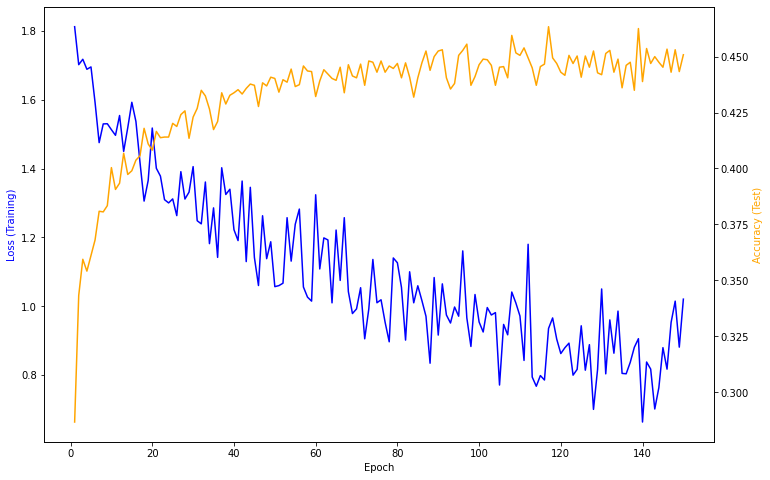

epoch: 149
Loss: 1.021
Accuracy (test set): 0.451
Training complete.  Elapsed time: 1168.0422444343567 seconds


In [ ]:
net4 = CNN4()
net4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net4.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net4,criterion,optimizer,dl_train,dl_test,150)

In [ ]:
test_model(net4, dl_train)

(0.5455446243286133,
 {'angry': 0.3879426266248319,
  'disgust': 0.2540650406504065,
  'fear': 0.27672545177443936,
  'happy': 0.7717632552404439,
  'neutral': 0.5053840631730079,
  'sad': 0.5527995622834215,
  'surprise': 0.6656441717791411})

Some prediction from the model defined above.



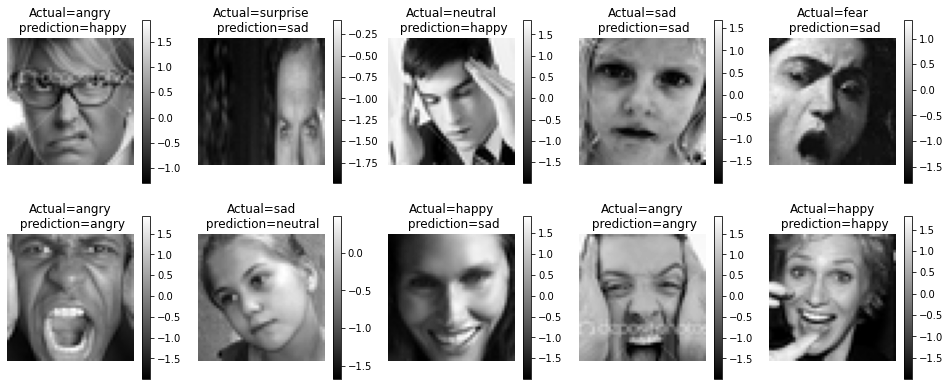

In [ ]:
show_examples_test(dl_test,net4,0,10)

##**Results**
From the three models tested above, the one which gave the highest overalll accuracy was the second model which was a relatively small convolutional neural network. it performed slightly better than the first model which was also a small convolutional network. The difference between the two was that the second one had more nodes / parameters and more hidden layers. The second one was also using batchnormalization and dropout. The second model was overfitting more than the first one, so I think what made the second one more accurate was just the increased number of nodes in the layers. The third model which was a much deeper convolutional network actually performed the worst out of the of them. My intuition was that more convolutional layers leads to more accuracy and my reasoning behing that was that more convolutional layers would allow the model to extract more features from the input data, but this was obviously not the case. This could be because increasing the number layers and parameters unnecessarily can easily lead to overfitting especially when we have a realtively small amount of data which is true in our case. I think another highly likely cause for the low performance of the third network is the vanisihing gradient problem which is a common problem in deeper networks. Overall, the second model gave the highest accuracy and that's the one I will be using in the next part of the project whihc is data augmentation.

#**Data Augmentation**
Next I will be doing data augmentation the images to try and make the model more accurate. The augmentation will be done using 3 different transformation which are random rotation, cropping and horizontal flipping. I will be applying the transformation to the enitre data set and then combining that will the original dataset and then train the model on the original and augmented data. In data augmentation, it is really important to make sure that the transformation your're using to augment the data are actually relevant to the given problem. Rotaton of images is relevant as We can have images with faces orientated different ways. Horizontal flipping is relevant is flipping someones face horizontally still gives us a perfectly normal looking face with a diffrent perspective, and cropping is relevant because we can clearly see from some of our images that some faces are very zoomed in and some are zoomed out. Thus these augmenations will help grow our dataset with meaningful data. I will first test with augmenting the whole dataset, then half the dataset, and then the whole dataset twice

The way I have done data augmentation is just by creating a copy of the original data, applying the transformations to it. Combining the transformed data with the original data and then retraining the model on the new combined data. Here I will be using the second model that was defined above and I will again be using a learninng rate of 0.001, beta values of (0.9,0.999) and a weight decay co-efficient of 0.0001.

##**First we will train with augmenting the whole dataset once**

In [ ]:
# In this cell we are augmenting the whole dataset and combining it with the priginal data

# create a copy of the images in a new variable
tensorX1 = np.copy(trainX)

# compose a transformation that rotates, crops, and flips the images randomly
transform1=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((48,48)),
                              transforms.RandomRotation((13),expand=True),
                              transforms.RandomCrop((38,38)),
                              transforms.RandomHorizontalFlip(0.6),
                              transforms.Resize((48,48))
                              ])

#apply the transformations to all the images
for x in range(len(tensorX1)):
  tensorX1[x] = transform1(tensorX1[x])

# concatenate the original images with the augmented images
augX = np.concatenate((trainX,tensorX1),axis = 0)
augY = np.concatenate((trainY,trainY),axis = 0)
# normalize the new data
normalize_transform2 = torchvision.transforms.Normalize(augX.mean(), augX.std())

# transform and create new datasets
augtrainX = normalize_transform2(torch.tensor(augX))
augtestX = normalize_transform2(torch.tensor(testX))

augtrainY = torch.tensor(augY)

train_data_aug = torch.utils.data.TensorDataset(augtrainX, augtrainY)

test_data_aug = torch.utils.data.TensorDataset(augtestX, tensortestY)
train_data_aug[:][0].shape

torch.Size([64596, 48, 48])

Displayed are some images with their corresponding augmented images

sad


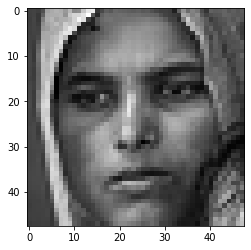

In [ ]:
num = 32297
trainX.shape
plt.imshow(trainX[num],cmap = plt.cm.gray )
print(classes[trainY[num]])

sad


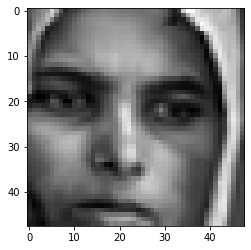

In [ ]:
#aug_data = torch.utils.data.TensorDataset(tensorX1, tensortrainY)
plt.imshow(augX[32298+num],cmap = plt.cm.gray)
print(classes[augY[32298+num]])

neutral


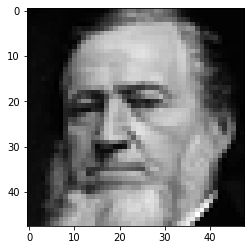

In [ ]:
num = 3500
trainX.shape
plt.imshow(trainX[num],cmap = plt.cm.gray )
print(classes[trainY[num]])

neutral


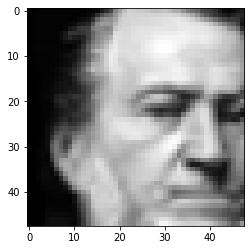

In [ ]:
#aug_data = torch.utils.data.TensorDataset(tensorX1, tensortrainY)
plt.imshow(augX[32298+num],cmap = plt.cm.gray)
print(classes[augY[32298+num]])

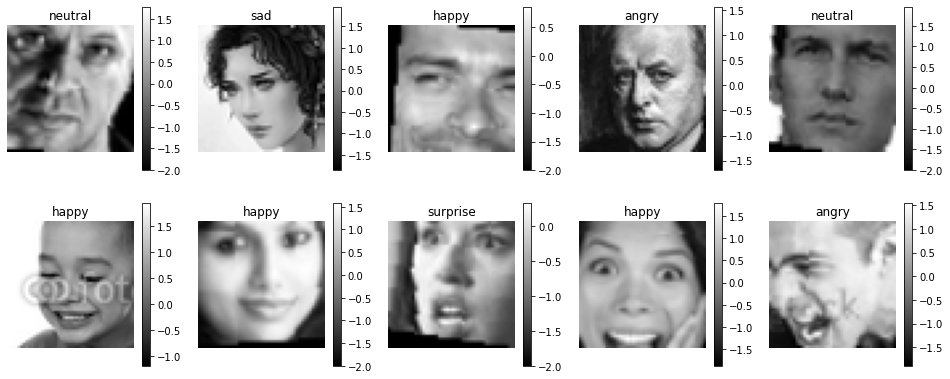

In [ ]:
# make a new training data loader with the new augmented set. we will use the same test set as before
dl_train1 = torch.utils.data.DataLoader(train_data_aug, batch_size,shuffle = True)
dl_test1 = torch.utils.data.DataLoader(test_data_aug, batch_size,shuffle = True)
show_examples(dl_train1)

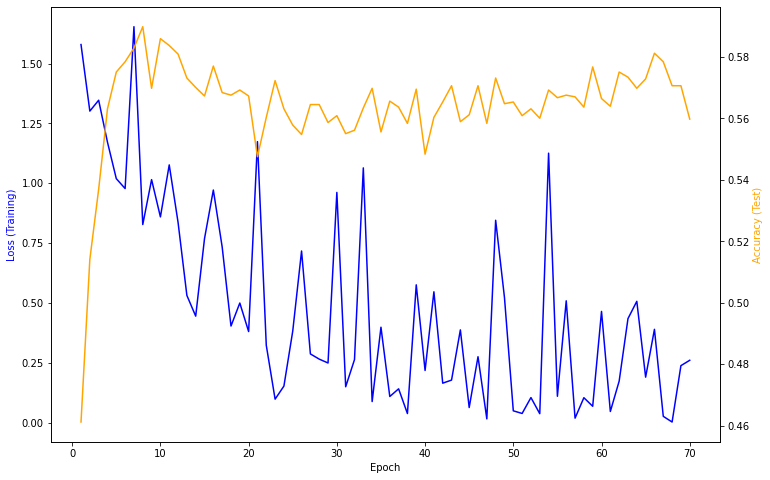

epoch: 69
Loss: 0.260
Accuracy (test set): 0.560
Training complete.  Elapsed time: 1210.7865099906921 seconds


In [ ]:
# train a new model with the augmented data
net5 = CNN2()
net5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net5.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net5,criterion,optimizer,dl_train1,dl_test1,70)

Training along with the augmented data increased the accuracy by about 2% from 54% to 56%. but again we can see that the accuracy is going down after around 10 epochs,  which again suggest the tthe model is overfitting. So we are going to train it again but this time just for 15 epochs.

In [ ]:
test_model(net5,dl_train1)

(0.9834200143814087,
 {'angry': 0.9850963693411027,
  'disgust': 0.9634146341463414,
  'fear': 0.9811669932505988,
  'happy': 0.9906905055487053,
  'neutral': 0.9737975592246949,
  'sad': 0.9822177639978115,
  'surprise': 0.9873117679866146})

###**Train again for 15 epochs**

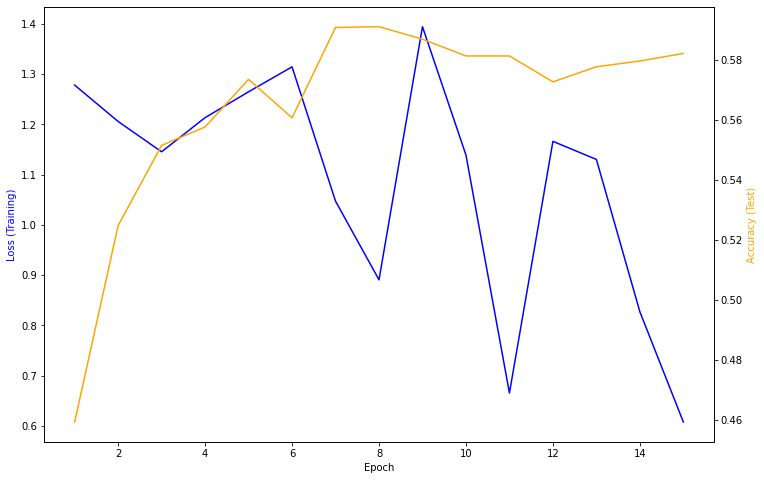

epoch: 14
Loss: 0.608
Accuracy (test set): 0.582
Training complete.  Elapsed time: 97.39111614227295 seconds


In [ ]:
# train with 15 epochs
net5 = CNN2()
net5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net5.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net5,criterion,optimizer,dl_train1,dl_test1,15)

Training for just 15 epochs gave us an extra 2% in the accuracy. Thus After doing data augmentaton we saw an overall increase of about 4 percent on the test set.

##**Now Train with augmenting just half the images**

In [ ]:
 # In this cell we are augmenting half the dataset and combining it with the priginal data

# create a copy of the images in a new variable
tensorX2 = np.copy(trainX[:16150])

#apply the transformations to all the images
for x in range(len(tensorX2)):
  tensorX2[x] = transform1(tensorX2[x])

# concatenate the original images with the augmented images
augX2 = np.concatenate((trainX,tensorX2),axis = 0)
augY2 = np.concatenate((trainY,trainY[:16150]),axis = 0)

# normalize the new data
normalize_transform2 = torchvision.transforms.Normalize(augX2.mean(), augX2.std())

# transform and create new datasets
augtrainX2 = normalize_transform2(torch.tensor(augX2))
augtestX2 = normalize_transform2(torch.tensor(testX))

augtrainY2 = torch.tensor(augY2)

train_data_aug2 = torch.utils.data.TensorDataset(augtrainX2, augtrainY2)

test_data_aug2 = torch.utils.data.TensorDataset(augtestX2, tensortestY)

# create dataloaders
dl_train2 = torch.utils.data.DataLoader(train_data_aug2, batch_size,shuffle = True)
dl_test2 = torch.utils.data.DataLoader(test_data_aug2, batch_size,shuffle = True)


In [ ]:
train_data_aug2[:][0].shape

torch.Size([48448, 48, 48])

In the pevious training we got the best result with 15 epochs, so we are going to train this one for 15 as well.

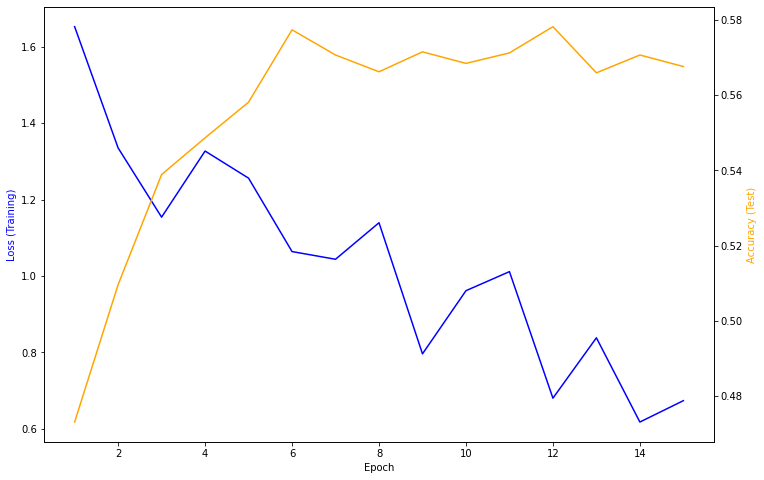

epoch: 14
Loss: 0.673
Accuracy (test set): 0.568
Training complete.  Elapsed time: 71.03646874427795 seconds


In [ ]:
net6 = CNN2()
net6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net6.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net6,criterion,optimizer,dl_train2,dl_test2,15)

We can see that by augmenting just half the data we ge an accuracy of about 56.8% which is quite close to the 58.2% we got with augmenting the whole dataset. So, so far increasing the amount of augmented data seems to be giving better results. Now we will try to augment the whole dataset twice.

##**Now Train with augmenting the whole dataset twice**

In [ ]:
 # In this cell we are augmenting half the dataset and combining it with the priginal data

# create a copy of the images in a new variable
tensorX3 = np.copy(trainX)
tensorX4 = np.copy(trainX)
#apply the transformations to all the images
for x in range(len(tensorX3)):
  tensorX3[x] = transform1(tensorX3[x])

for x in range(len(tensorX4)):
  tensorX4[x] = transform1(tensorX4[x])

# concatenate the original images with the augmented images
augX3 = np.concatenate((trainX,tensorX3, tensorX4),axis = 0)
augY3 = np.concatenate((trainY,trainY,trainY),axis = 0)

# normalize the new data
normalize_transform2 = torchvision.transforms.Normalize(augX3.mean(), augX3.std())

# transform and create new datasets
augtrainX3 = normalize_transform2(torch.tensor(augX3))
augtestX3 = normalize_transform2(torch.tensor(testX))

augtrainY3 = torch.tensor(augY3)

train_data_aug3 = torch.utils.data.TensorDataset(augtrainX3, augtrainY3)

test_data_aug3 = torch.utils.data.TensorDataset(augtestX3, tensortestY)

# create dataloaders
dl_train3 = torch.utils.data.DataLoader(train_data_aug2, batch_size,shuffle = True)
dl_test3 = torch.utils.data.DataLoader(test_data_aug2, batch_size,shuffle = True)

train_data_aug3[:][0].shape


torch.Size([96894, 48, 48])

Train for 15 epochs

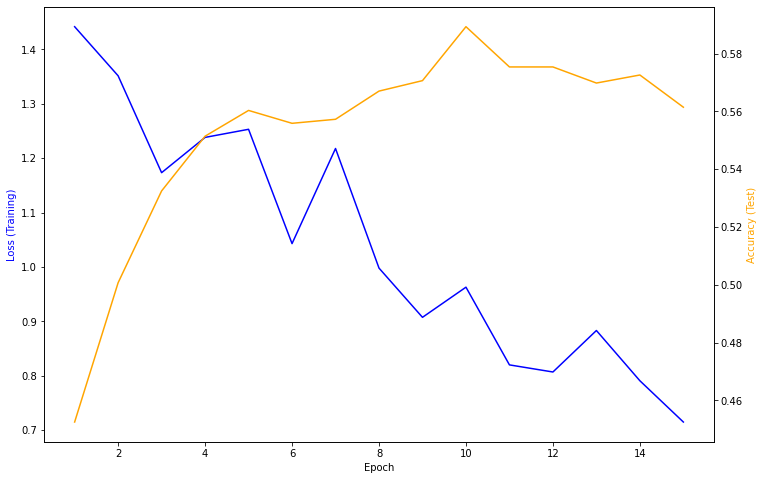

epoch: 14
Loss: 0.715
Accuracy (test set): 0.561
Training complete.  Elapsed time: 71.80100274085999 seconds


In [ ]:
net7 = CNN2()
net7.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net7.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model(net7,criterion,optimizer,dl_train3,dl_test3,15)

This time, by augmenting the whole dataset twice, the accuracy was 56.1% which is about 2% less than what we got by just transformaing the dataset once. This suggests that while dataaugmentation is a good tool for increasing the amount of data, it has to be used in moderation as adding too much augmented data will eventually lead to overfitting. In our case, with the transformation I applied, I found that transforming the whole data just once gave the best results through data augmentation which was an increase in accuracy by 4%.

## **Results of Data augmentation**
Overall, we did get good results from data augmentation. We saw an overall increase of about 4% in the accuracy which is not as much as I was hoping, but I think the 3 transformations that were used, although they were relevant in our case didn't really change the data that much to allow the model learn to new features in the images. We did see a slight increase in accuracy from augmenting just half the data to the whole dataset, but augmenting the whole dataset twice actually lead to a decrease in accuracy which suggests the the new augmented data wasn't really giving the model any new and useful information and was just contributing towards overfitting.

#**Transfer Learning**

Next we will be using transfer learning to maximize the accuracy on our dataset. Here, first I will be using the resnet18 data set which is an image classification model with 18 layers. I will first train on a pre-trained model with all the layers except for the last one frozen. Then I will train a pre-trained model with all layers unfrozend with the original dataset and then agian with the augmented dataset. After that I will also train it once on resnet50 which is another images classification model with 50 layers.

To be able to use my dataset on the resnet 18 and restnet50 models, there was some preprocessing required to make the images usable with those models. Both resnet18 and 50 use Rgb 3 channel images of size 224 x 224. Fer2013 is consists of gray scale 1 channel 48 x 48 images. So we first have to convert these images to have 3 channels and a size of 224 x 224. The 1 channel images were converted to 3 channels by just stacking the images on top of each other 3 times and the size was changed using the transfomrs.resize function in pytorch. These transformation were applied whilst training as the mini-batches helped with reducing the amount of memory that was being used. It was possible to do all the transformation all together before training, but with that approach colab kept on running out of memory and the session  kept on crashing. To apply these transformation during training, we will be modifying out training and testing function.

The resnet networks are very deep so training was taking alot longer with them which is why I will be using just 10 epochs in the following experiments unless otherwise noted.

In [ ]:
def train_model_2(model, loss_func, optimizer, traindata, epochs):

    transforms_resize = transforms.Compose([
                                  transforms.Resize(224),
                                  ])

    #start_time = plot_start_time = time.time()

    #losses = []
    #accuracies = []
    #start_time = time.time()
    stats.start()
    for epoch in range(epochs):

        running_loss = 0.0

        for i, data in enumerate(traindata):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]
            inputs =inputs[:,None,:,:]
            inputs = transforms_resize(inputs)
            inputs = inputs.squeeze(1)
            rgb_batch = torch.stack([inputs,inputs,inputs],0)
            rgb_batch = rgb_batch.permute(1,0,2,3)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(rgb_batch)
            # backprop
            loss = loss_func(outputs, labels)
            loss.backward()
            # optimize (update weights)
            optimizer.step()

            stats.iteration(epoch,i,loss)

    stats.end()

In [ ]:
def test_model2(model, dataloader):
    classes = ["angry","disgust","fear","happy","sad","surprise","neutral"]
    class_correct = {clsname: 0 for clsname in classes}
    class_total = {clsname: 0 for clsname in classes}
    total_correct = 0
    total = 0

    transforms_resize = transforms.Compose([
                                  transforms.Resize(224),
                                  ])

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = [x.to(device) for x in data]
            inputs =inputs[:,None,:,:]
            inputs = transforms_resize(inputs)
            inputs = inputs.squeeze(1)
            rgb_batch = torch.stack([inputs,inputs,inputs],0)
            rgb_batch = rgb_batch.permute(1,0,2,3)

            # forward
            outputs = model(rgb_batch)

            # get predictions from multiple class outputs
            _, predicted = torch.max(outputs, 1)
            # find and count the correct predictions
            corrects = (predicted == labels).squeeze()
            total_correct += corrects.sum()
            total += outputs.shape[0]

            # count correct predictions within each clsas
            for label, correct in zip(labels, corrects):
                clsname = classes[label]
                class_correct[clsname] += correct.item()
                class_total[clsname] += 1

    # compute overall accuracies
    accuracy = (total_correct / total).item()
    class_accuracies = {clsname: class_correct[clsname]/class_total[clsname]
                        for clsname in classes}

    return accuracy, class_accuracies

## Resnet18 pre-trained with all layers forzen

In [ ]:
# get the model
model0 = torchvision.models.resnet18( pretrained = True )

#freeze all layers
for param in model0.parameters():
    param.requires_grad = False

# replace the final layer
model0.fc = nn.Linear(512,7)

# transfer model to gpu
model0 = model0.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model0.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model_2(model0,criterion,optimizer,dl_train1,10)

In [ ]:
test_model2(model0 ,dl_test)

(0.43744778633117676,
 {'angry': 0.1670061099796334,
  'disgust': 0.18181818181818182,
  'fear': 0.13257575757575757,
  'happy': 0.7155858930602957,
  'neutral': 0.4712460063897764,
  'sad': 0.468013468013468,
  'surprise': 0.4951923076923077})

Transfer learning with Resnet18 pretrained anf freezing all the layers and using just the last layer gave an overall accuracy of 43.7%. This makes sense because resnet18 is an images classfication model that is not specifically for facial or emotion recognition. So we can't really expect it to do well on new data without any trainig.

##Resnet18 pretrained with all layers unfrozen using the just the original dataset

In [ ]:
# get the model
model = torchvision.models.resnet18( pretrained = True )

# replace the final layer
model.fc = nn.Linear(512,7)

# transfer model to gpu
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model_2(model,criterion,optimizer,dl_train,10)

In [ ]:
test_model2(model,dl_test)

(0.6205071210861206,
 {'angry': 0.5295315682281059,
  'disgust': 0.4909090909090909,
  'fear': 0.3939393939393939,
  'happy': 0.8703071672354948,
  'neutral': 0.5399361022364217,
  'sad': 0.5505050505050505,
  'surprise': 0.7259615384615384})

Transfer learning with resnet18 using all the layers for training with just the original dataset gave us an overall accuracy of 62% that is a jump of 4% from our previous highest of 58% that we got with training with data augmentation. So, transfer learning with all the layers unfrozen is giving good results and is looking promising as it was able to get us a higher accuracy on the original dataset than what we got with data-augmentation.

##Resnet18 pretrained with all layers unfrozen using the augmented data set

In [ ]:
# get the model
model2 = torchvision.models.resnet18( pretrained = True )

# replace the final layer
model2.fc = nn.Linear(512,7)

# transfer model to gpu
model2 = model2.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model_2(model2,criterion,optimizer,dl_train1,10)

In [ ]:
test_model2(model2,dl_test1)

(0.6631373763084412,
 {'angry': 0.5661914460285132,
  'disgust': 0.6181818181818182,
  'fear': 0.5208333333333334,
  'happy': 0.8646188850967008,
  'neutral': 0.6309904153354633,
  'sad': 0.5723905723905723,
  'surprise': 0.7163461538461539})

Now using transfer learning with all layers unfrozen and using the augmented data as well lead to increase in accuracy by 2%. So, again data augmentation is proving to be a useful technique. Since we are getting better results with data augmentation, I am going to run the same training again but this time for 30 epochs instead of 10 to see if we can squeeze more performance from the model

**Train again, but this time for 30 epochs**

In [ ]:
# get the model
model2 = torchvision.models.resnet18( pretrained = True )

# replace the final layer
model2.fc = nn.Linear(512,7)

# transfer model to gpu
model2 = model2.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model_2(model2,criterion,optimizer,dl_train1,30)

With just 10 epochs we got to an accuracy of 66% but after 30 epochs the accuracy increases to 68% which is the highest we have achieved do far. I do think we might be able to improve slightly more on this with more epochs.

##Resnet 50 pre-trained with alllayers frozen using the augmented dataset
Next we will be training with the Resnet50 model. The mian difference between Resent 18 and 50 is the number of layers which are 18 and 50 respecively. For this experiment, my hypothesis is that resnet50 will not perform better than Resent18. This is based on the results from training the third model that I implemented above, where we defined a much deeper convolutional network and it ended up giving us the worst results out of all of them. With Resent50 also being much deeper, I am expecting similar results from it.

In [ ]:
model3 =  torchvision.models.resnet50( pretrained = True )

# replace the final layer
model3.fc = nn.Linear(2048,7)

# transfer model to gpu
model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

train_model_2(model3,criterion,optimizer,dl_train1,10)
# train the model

In [ ]:
test_model2(model3,dl_test1)

(0.6522708535194397,
 {'angry': 0.615071283095723,
  'disgust': 0.509090909090909,
  'fear': 0.5340909090909091,
  'happy': 0.8418657565415245,
  'neutral': 0.6246006389776357,
  'sad': 0.4663299663299663,
  'surprise': 0.7716346153846154})

And with Resnet50 we got an accuracy of 65% on the test set after training for 10 epochs. For comparison Resent18 got around 66% with 10 epochs. This kinda confirms my hypothesis even though the results weren't as bad as The third model I implemented. This again goes to show that for our dataset and smaller datasets in general, it is best to stick with small and shallow networks.

#**Summary**
- We tried different architectures for our implementation of a convolutional network and we found that it was best to keep the model relatively small. A deeper network seemed to be giving the worst results. Adding batchnormalization and dropout in our model also helped in reduce overfitting and increasing the accuracy.
- We then augmented our data. We tried adding different amount of augmented data. First we augmnted the whole original dataset, then 1/2 of it and then the whole dataset twice. Augmenting 1/2 of the data gave us good results and doing whole dataset gave us even better results, but going any farther than that as in the case of augmenting the dataset twice lead to overfitting and drop in accuracy.
- We then performed transfer learning with Resnet 18 which is an image classification model. we did see a pretty good increase in accuracy as we went from 58% to 64% but it did take alot longer to train with transfer learning. I then performd transfer learing with the augmented data as well and this gave a
further increase of 2% in the accuracy which was around 66% and after trainning it for more epochs we were able to get to a peak accuracy of 68%. In short, according to my results from transfer learning is probably the best way to apprach image classification problems. The training does take longer but the increase in accuracy is also significant.

#**What I learned**
- Statring this project I thought I would have been able to get a relatively high accuracy by implementing my own network from scratch, but I learned this this was not the case. The highest accuracy I got was 68% which, after a bit of research I figured was not that bad as the highest anyone had achieved on this dataset is around 75% accuracy. Regardless, I learned that in order to train a neural with very high accuracy and one that can be reliably used in a practical usecase is actually a very difficult task. I realized that to implement a very accurate neural network often requires tremendous amounts of data, experimentation and computational power.
- I learned that although there is alot of theory regarding deep learning techniques, a lot of it, at least in the case of this project, was based on trial and error. A lot of times when I tried to search for how to approach a specific problem, more of what I found simply said to try multiple approaches and go with whatever stuck, ofcourse there was some amount of theory imvolved as well, but most of it was just random experimentation.
- I was introduced to and had to try out alot of new things whilst working on this project. This meant that along each and every step I kept on running into countless problems and errors. Having to constantly deal with such errors had really improved by debugging skills such as quickly recognizing errors, searching possible solution and help online and reading documentation. I learned it was critical to carefully go through very line of code because it was often the case that a very simple mistake was causing huge problems in the code.
- I learned that more training dosen't always lead to better performance because of overfitting.
- Apart from all this, this project definitely gave me a lot more in sight into the world of deep learning which has increased my interest in this field even further. I definitely plan on imporving on this project and taking on more deep learning projects in the future.

#**Future Imporvements**
- A really important next step would be to perform a very detailed hyperparameter seacrh using these models. Here, I didn't really pay much attention to hyperparameter tuning and mostly just went with the default parameters supplied by the optimizers.
- We can look into performing transfer learning with various other models as well such as VGG16.
-Something that might improve the data augmentation and make it more efficient than what I have done is to perform the data augmentation transformations whilst the netwrok was training over the mini-batches instead of just augmentatiing the data before hand like I did.
- I only tested 3 different models and I think a better model can be found if more experimentation was done and more models using different techniques were tested as well.

-